In [1]:
# Core
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Sklearn
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

# XGBoost
from xgboost import XGBRegressor

# Optional: suppress warnings
import warnings
warnings.filterwarnings("ignore")

In [2]:
X = pd.read_csv("rdkit_descriptors.csv")
y = pd.read_csv("drd2_cleaned_dataset.csv")["pIC50"]

X.shape, y.shape

((890, 193), (890,))

In [3]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42
)

X_train.shape, X_test.shape

((712, 193), (178, 193))

In [4]:
rf = RandomForestRegressor(
    n_estimators=200,
    random_state=42,
    n_jobs=-1
)

rf.fit(X_train, y_train)

RandomForestRegressor(n_estimators=200, n_jobs=-1, random_state=42)

In [5]:
# Predictions
y_train_pred = rf.predict(X_train)
y_test_pred = rf.predict(X_test)

# Metrics
def evaluate(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    return rmse, mae, r2

train_metrics = evaluate(y_train, y_train_pred)
test_metrics = evaluate(y_test, y_test_pred)

train_metrics, test_metrics

((np.float64(0.39679376908705455), 0.26735263749970095, 0.907672806390684),
 (np.float64(0.7369278031318454), 0.5578707562455856, 0.5506599340720205))

In [6]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)

cv_r2 = cross_val_score(rf, X_train, y_train, cv=kf, scoring="r2")
cv_rmse = -cross_val_score(rf, X_train, y_train, cv=kf, scoring="neg_root_mean_squared_error")

cv_r2.mean(), cv_r2.std(), cv_rmse.mean(), cv_rmse.std()

(np.float64(0.33385627873127177),
 np.float64(0.14395620899589512),
 np.float64(1.0570933405251597),
 np.float64(0.18239429670711532))

In [7]:
param_grid = {
    "max_depth": [None, 10, 20],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
    "max_features": ["sqrt", 0.5]
}

grid = GridSearchCV(
    RandomForestRegressor(
        n_estimators=200,
        random_state=42,
        n_jobs=-1
    ),
    param_grid,
    cv=kf,
    scoring="r2",
    n_jobs=-1
)

grid.fit(X_train, y_train)

grid.best_params_, grid.best_score_

({'max_depth': 10,
  'max_features': 0.5,
  'min_samples_leaf': 1,
  'min_samples_split': 2},
 np.float64(0.33097623419683775))

In [8]:
best_rf = grid.best_estimator_

y_train_pred = best_rf.predict(X_train)
y_test_pred = best_rf.predict(X_test)

train_metrics = evaluate(y_train, y_train_pred)
test_metrics = evaluate(y_test, y_test_pred)

train_metrics, test_metrics

((np.float64(0.5201906874905085), 0.3759210276022667, 0.8413189397240498),
 (np.float64(0.7484183700783128), 0.5742398673099812, 0.5365379928495585))

In [9]:
xgb = XGBRegressor(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1
)

xgb.fit(X_train, y_train)

y_train_pred = xgb.predict(X_train)
y_test_pred = xgb.predict(X_test)

train_metrics = evaluate(y_train, y_train_pred)
test_metrics = evaluate(y_test, y_test_pred)

train_metrics, test_metrics

((np.float64(0.04724678262690163), 0.02656444909399886, 0.9986909855923481),
 (np.float64(0.7832698696017033), 0.5824938275141237, 0.4923690395925747))

In [10]:
xgb_reg = XGBRegressor(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=3,
    subsample=0.7,
    colsample_bytree=0.7,
    reg_alpha=1,        # L1 regularization
    reg_lambda=5,       # L2 regularization
    random_state=42,
    n_jobs=-1
)

xgb_reg.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    verbose=False
)

y_train_pred = xgb_reg.predict(X_train)
y_test_pred = xgb_reg.predict(X_test)

train_metrics = evaluate(y_train, y_train_pred)
test_metrics = evaluate(y_test, y_test_pred)

train_metrics, test_metrics

((np.float64(0.5571570421214515), 0.393035301389572, 0.8179648753112625),
 (np.float64(0.7633139596689187), 0.5701161172718152, 0.5179060621833226))

In [11]:
cv_r2_xgb = cross_val_score(xgb_reg, X_train, y_train, cv=kf, scoring="r2")
cv_r2_xgb.mean(), cv_r2_xgb.std()

(np.float64(0.2641563384817105), np.float64(0.13167860345716267))

In [12]:
results = pd.DataFrame({
    "Model": ["RF Tuned", "XGB Regularized"],
    "Train R2": [0.84, 0.82],
    "Test R2": [0.54, 0.52],
    "CV Mean R2": [0.33, 0.26]
})

results

,Model,Train R2,Test R2,CV Mean R2
0,RF Tuned,0.84,0.54,0.33
1,XGB Regularized,0.82,0.52,0.26


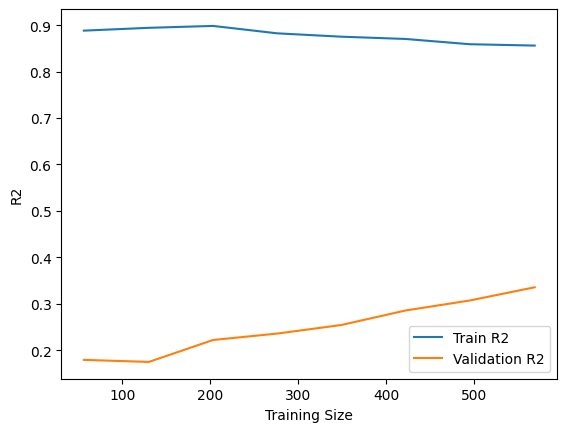

In [13]:
from sklearn.model_selection import learning_curve

train_sizes, train_scores, val_scores = learning_curve(
    best_rf,
    X_train,
    y_train,
    cv=kf,
    scoring="r2",
    train_sizes=np.linspace(0.1, 1.0, 8),
    n_jobs=-1
)

train_mean = train_scores.mean(axis=1)
val_mean = val_scores.mean(axis=1)

plt.plot(train_sizes, train_mean, label="Train R2")
plt.plot(train_sizes, val_mean, label="Validation R2")
plt.xlabel("Training Size")
plt.ylabel("R2")
plt.legend()
plt.show()

In [18]:
X = pd.read_csv("morgan_fingerprints.csv")
y = pd.read_csv("drd2_cleaned_dataset.csv")["pIC50"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42
)

X.shape, X_train.shape

((890, 990), (712, 990))

In [16]:
X = pd.read_csv("morgan_fingerprints.csv")
X.shape

(890, 990)

In [17]:
y = pd.read_csv("drd2_cleaned_dataset.csv")["pIC50"]
y.shape

(890,)

In [19]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Load Morgan fingerprints
X = pd.read_csv("morgan_fingerprints.csv")
y = pd.read_csv("drd2_cleaned_dataset.csv")["pIC50"]

print("X shape:", X.shape)
print("y shape:", y.shape)

X shape: (890, 990)
y shape: (890,)


In [20]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42
)

print(X_train.shape, X_test.shape)

(712, 990) (178, 990)


In [21]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

rf_morgan = RandomForestRegressor(
    n_estimators=200,
    random_state=42,
    n_jobs=-1
)

rf_morgan.fit(X_train, y_train)

# Predictions
y_train_pred = rf_morgan.predict(X_train)
y_test_pred = rf_morgan.predict(X_test)

def evaluate(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    return rmse, mae, r2

train_metrics = evaluate(y_train, y_train_pred)
test_metrics = evaluate(y_test, y_test_pred)

train_metrics, test_metrics

((np.float64(0.4132954274735193), 0.25446297739473345, 0.8998338115246548),
 (np.float64(0.6683373262104235), 0.4942352349214017, 0.6304129936230859))

In [22]:
from sklearn.model_selection import KFold, cross_val_score

kf = KFold(n_splits=5, shuffle=True, random_state=42)

cv_r2_morgan = cross_val_score(rf_morgan, X_train, y_train, cv=kf, scoring="r2")
cv_r2_morgan.mean(), cv_r2_morgan.std()

(np.float64(0.34773572473582165), np.float64(0.10655885038422971))

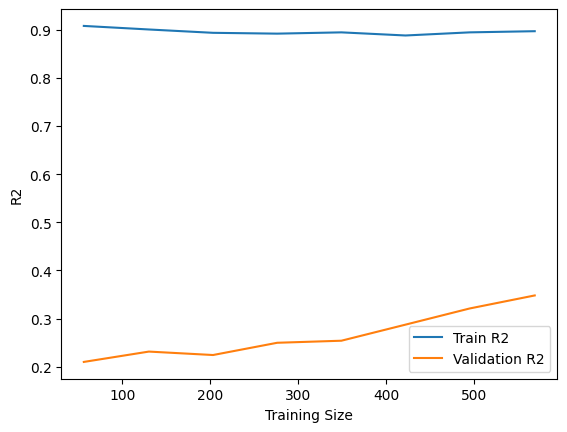

In [23]:
from sklearn.model_selection import learning_curve

train_sizes, train_scores, val_scores = learning_curve(
    rf_morgan,
    X_train,
    y_train,
    cv=kf,
    scoring="r2",
    train_sizes=np.linspace(0.1, 1.0, 8),
    n_jobs=-1
)

train_mean = train_scores.mean(axis=1)
val_mean = val_scores.mean(axis=1)

plt.plot(train_sizes, train_mean, label="Train R2")
plt.plot(train_sizes, val_mean, label="Validation R2")
plt.xlabel("Training Size")
plt.ylabel("R2")
plt.legend()
plt.show()

In [24]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

# Load both
desc = pd.read_csv("rdkit_descriptors.csv")
morgan = pd.read_csv("morgan_fingerprints.csv")

# Combine
X_combined = np.hstack([desc.values, morgan.values])
y = pd.read_csv("drd2_cleaned_dataset.csv")["pIC50"]

print("Combined shape:", X_combined.shape)

Combined shape: (890, 1183)


In [25]:
X_train, X_test, y_train, y_test = train_test_split(
    X_combined,
    y,
    test_size=0.2,
    random_state=42
)

print(X_train.shape, X_test.shape)

(712, 1183) (178, 1183)


In [26]:
rf_combined = RandomForestRegressor(
    n_estimators=300,
    max_depth=8,              # restrict depth
    min_samples_leaf=5,       # stronger regularization
    min_samples_split=10,
    max_features=0.3,         # use fewer features per split
    random_state=42,
    n_jobs=-1
)

rf_combined.fit(X_train, y_train)

# Predictions
y_train_pred = rf_combined.predict(X_train)
y_test_pred = rf_combined.predict(X_test)

train_metrics = evaluate(y_train, y_train_pred)
test_metrics = evaluate(y_test, y_test_pred)

train_metrics, test_metrics

((np.float64(0.7823154960617716), 0.5118838864935112, 0.6411079707760703),
 (np.float64(0.7485133143104585), 0.568923736474428, 0.5364203959618645))

In [27]:
cv_r2_combined = cross_val_score(
    rf_combined,
    X_train,
    y_train,
    cv=kf,
    scoring="r2"
)

cv_r2_combined.mean(), cv_r2_combined.std()

(np.float64(0.3208642518235457), np.float64(0.1066089189716023))